TextBlob:

It is less sophisticated than deep learning models like FinBERT but provides a quick baseline for sentiment evaluation

In [3]:
# Getting Sentiment Score with VADER
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import BertTokenizer, BertForSequenceClassification
import time
import torch
from tqdm import tqdm
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from huggingface_hub import login
import os
import torch.nn.functional as F
import numpy as np

In [4]:
# Load your cleaned data (ensure the CSV file path is correct)
df = pd.read_csv('/notebooks/18MONTHTWEETS.csv')
df.head(10)

Date                                               text  \
0  2018-01-01  023 ultima r$ 4774999 alta r$ 4950000 baixa r$...   
1  2018-01-01  $btc 088 13673$ top 1h $neog 3072 95st $pac 21...   
2  2018-01-01  the would be worth us$13607000000 right now do...   
3  2018-01-01  bitcoin cash $232583 448 $10917 high $241500 l...   
4  2018-01-01             bitcoin $btc is trading at 1342100 usd   
5  2018-01-01  btc average 1388489$ bitfinex 1339400$ polonie...   
6  2018-01-01   02 ocak 2018 saat 020002 1 btc kaç tl 5115680 tl   
7  2018-01-01  btc average 1397324$ bitfinex 1353700$ polonie...   
8  2018-01-01  0102 0700 crypto currency sentiment analysis b...   
9  2018-01-01  bitcoin $13523 295 $41100 high $14050 low $127...   

                                        cleaned_text    month  
0  023 ultima r $ 4774999 alta r $ 4950000 baixa ...  2018-01  
1  $ btc 088 13673 $ top 1h $ neog 3072 95st $ pa...  2018-01  
2  would worth u $ 13607000000 right 431 last 24 ...  2018-01  
3  bitcoin cash $ 232583 448 $ 10917 high $ 24150...  2018-01  
4                  bitcoin $ btc trading 1342100 usd  2018-01  
5  btc average 1388489 $ bitfinex 1339400 $ polon...  2018-01  
6   02 ocak 2018 saat 020002 1 btc kaç tl 5115680 tl  2018-01  
7  btc average 1397324 $ bitfinex 1353700 $ polon...  2018-01  
8  0102 0700 crypto currency sentiment analysis b...  2018-01  
9  bitcoin $ 13523 295 $ 41100 high $ 14050 low $...  2018-01

In [5]:
print(df['cleaned_text'].isnull().sum())
# SOME MISSING NAN FOUND LETS CLEARN DATA FUERTHER

24763


In [6]:
df['cleaned_text'] = df['cleaned_text'].fillna('')

In [8]:
# We need only date and clean_text column
df = df[["Date", "cleaned_text"]]

In [9]:
df = df.rename(columns={"cleaned_text": "text"})  # Rename 'cleaned_text' to 'text'

In [10]:
# Trim column names to remove accidental spaces
df.columns = df.columns.str.strip()

# Ensure 'text' is in the correct format (string)
df["text"] = df["text"].astype(str)

# Load Twitter-RoBERTa model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# **Enable GPU Acceleration**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"✅ Using device: {device}")

# **Batch Processing Function**
def get_roberta_sentiments_batch(texts, batch_size=32):
    sentiments = []
    sentiment_scores = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Processing Batches"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)

        # Move inputs to GPU if available
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        scores = F.softmax(outputs.logits, dim=-1)  # Convert logits to probabilities
        predicted_classes = torch.argmax(scores, dim=-1).cpu().numpy()

        sentiment_labels = ["Negative", "Neutral", "Positive"]
        sentiments.extend([sentiment_labels[pred] for pred in predicted_classes])
        sentiment_scores.extend(scores.cpu().tolist())

    return sentiments, sentiment_scores

# **Apply Batch Processing**
df["Sentiment"], df["Sentiment_Scores"] = get_roberta_sentiments_batch(df["text"].tolist(), batch_size=32)

# **Save results**
output_path = "/notebooks/Sentiment_RoBERTa.csv"
df.to_csv(output_path, index=False)

print(f"✅ RoBERTa sentiment analysis complete! Results saved to: {output_path}")


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

✅ Using device: cuda


Processing Batches:  77%|███████▋  | 37929/49314 [2:27:54<53:25,  3.55it/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Processing Batches: 100%|██████████| 49314/49314 [3:11:20<00:00,  4.30it/s]  


✅ RoBERTa sentiment analysis complete! Results saved to: /notebooks/Sentiment_RoBERTa.csv


In [11]:
# Load the processed dataset
df_RoBERTa = pd.read_csv('/notebooks/Sentiment_RoBERTa.csv')

# Display first 10 rows
print(df_RoBERTa.head(10))


         Date                                               text Sentiment  \
0  2018-01-01  023 ultima r $ 4774999 alta r $ 4950000 baixa ...   Neutral   
1  2018-01-01  $ btc 088 13673 $ top 1h $ neog 3072 95st $ pa...   Neutral   
2  2018-01-01  would worth u $ 13607000000 right 431 last 24 ...   Neutral   
3  2018-01-01  bitcoin cash $ 232583 448 $ 10917 high $ 24150...   Neutral   
4  2018-01-01                  bitcoin $ btc trading 1342100 usd   Neutral   
5  2018-01-01  btc average 1388489 $ bitfinex 1339400 $ polon...   Neutral   
6  2018-01-01   02 ocak 2018 saat 020002 1 btc kaç tl 5115680 tl   Neutral   
7  2018-01-01  btc average 1397324 $ bitfinex 1353700 $ polon...   Neutral   
8  2018-01-01  0102 0700 crypto currency sentiment analysis b...   Neutral   
9  2018-01-01  bitcoin $ 13523 295 $ 41100 high $ 14050 low $...   Neutral   

                                    Sentiment_Scores  
0  [0.05376371368765831, 0.9148882627487183, 0.03...  
1  [0.23525990545749664, 0.7329

In [13]:
import pandas as pd
import ast

# Load the RoBERTa sentiment results CSV
df = pd.read_csv("/notebooks/Sentiment_RoBERTa.csv")

# Convert 'Sentiment_Scores' from a string to a list using ast.literal_eval
df["Sentiment_Scores"] = df["Sentiment_Scores"].apply(ast.literal_eval)

# Compute the compound sentiment score:
# Weighted Sentiment = (Positive - Negative) * (1 - Neutral)
df["Sentiment_Score"] = df["Sentiment_Scores"].apply(lambda x: (x[2] - x[0]) * (1 - x[1]))

# Keep only the necessary columns for prediction
df_final = df[["Dateyt", "text", "Sentiment_Score"]]

# Save the final dataset to a new CSV file
output_path = "/notebooks/Sentiment_RoBERTa.csv"
df_final.to_csv(output_path, index=False)

print(f"✅ Final dataset with computed sentiment score saved to: {output_path}")


✅ Final dataset with computed sentiment score saved to: /notebooks/Sentiment_RoBERTa.csv


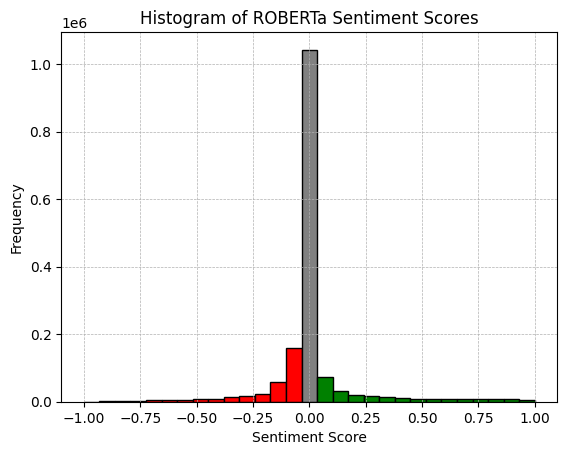

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the final dataset with 'Sentiment_Score'
df = pd.read_csv("/notebooks/Sentiment_RoBERTa.csv")

# Extract the Sentiment_Score values
data = df["Sentiment_Score"]

# Define bins between -1 and 1 (adjust the number of bins as needed)
bins = np.linspace(-1, 1, 30)

# Plot the histogram and capture the patches (bars)
counts, edges, patches = plt.hist(data, bins=bins, edgecolor='black')

# Colorize each bin based on its range:
# Red for negative sentiment, Green for positive sentiment, Grey for neutral
for patch, left, right in zip(patches, edges[:-1], edges[1:]):
    if right <= 0:   # Entire bin is negative
        patch.set_facecolor('red')
    elif left >= 0:  # Entire bin is positive
        patch.set_facecolor('green')
    else:            # Bin spans negative and positive (neutral)
        patch.set_facecolor('grey')

# Add grid lines, labels, and title
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Histogram of ROBERTa Sentiment Scores")
plt.show()


In [ ]:
import pandas as pd
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report

# ✅ Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# ✅ Load Roberta-based Sentiment Model & Tokenizer
# We're using the CardiffNLP model fine-tuned for Twitter sentiment
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name).to(device)
model.eval()  # Set to evaluation mode for faster inference

# ✅ Load and Prepare Test Data
test_df = pd.read_csv('/notebooks/kaggle/test_set_done_anotate_clean.csv')
# Ensure you have a text column; fill any missing values with empty strings
test_df['text'] = test_df['text'].fillna('').astype(str)
# Drop rows with missing sentiment_numeric values
test_df = test_df.dropna(subset=['sentiment_numeric'])

# ✅ Define Batch Processing Function for Roberta
def get_roberta_sentiment_scores(texts, batch_size=32):
    """Process texts in batches and return predicted class indices."""
    predictions = []
    total_batches = len(texts) // batch_size + (1 if len(texts) % batch_size != 0 else 0)
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing Sentiment", unit="batch", ncols=80):
        batch_texts = texts[i:i + batch_size]
        
        # Tokenize and convert to input tensors
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Compute probabilities using softmax from torch.nn.functional
        probs = F.softmax(outputs.logits, dim=-1)
        # Get the predicted class (argmax along the last dimension)
        batch_preds = torch.argmax(probs, dim=-1).cpu().numpy()
        predictions.extend(batch_preds)
        
    return predictions

# ✅ Get predictions on the test texts
test_texts = test_df['text'].tolist()
predicted_class_indices = get_roberta_sentiment_scores(test_texts)

# Mapping: the model outputs classes as 0, 1, 2 which correspond to:
# 0 -> negative, 1 -> neutral, 2 -> positive.
# Adjust these to match your numeric labels: negative (-1.0), neutral (0.0), positive (1.0)
index_to_numeric = {0: -1.0, 1: 0.0, 2: 1.0}
predicted_numeric = [index_to_numeric[idx] for idx in predicted_class_indices]

# ✅ Evaluate the model using the sentiment_numeric column from your test data
true_numeric = test_df['sentiment_numeric'].tolist()
accuracy = accuracy_score(true_numeric, predicted_numeric)
print("Accuracy (numeric):", accuracy)
print("\nClassification Report (numeric):")
print(classification_report(true_numeric, predicted_numeric))